<a href="https://colab.research.google.com/github/jenelaineDC/Master-Time-Series-Analysis-Forecasting/blob/main/GOOGLE%20TSMIXER/Google_TS_Mixer_Bike_Share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GOOGLE TSMIXER

[Documentation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tsmixer_model.html)

[Journal](https://arxiv.org/abs/2303.06053)

TSMixer (Time-series Mixer) is an all-MLP architecture for time series forecasting.

It does so by integrating historical time series data, future known inputs, and static contextual information. The architecture uses a combination of conditional feature mixing and mixer layers to process and combine these different types of data for effective forecasting.

Translated to Darts, this model supports all types of covariates (past, future, and/or static).

### SET-UP

In [3]:
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series/Google TS Mixer

/content/drive/MyDrive/Python - Time Series Forecasting/Advanced Content for Time Series/Google TS Mixer


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterSampler

from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TSMixerModel

In [5]:
data = pd.read_csv('bike data.csv')
data.head()

Date  Season  Hour  Holiday  Day of the Week  Working Day  \
0  1/1/2011       4     0        0                6            0   
1  1/1/2011       4     1        0                6            0   
2  1/1/2011       4     2        0                6            0   
3  1/1/2011       4     3        0                6            0   
4  1/1/2011       4     4        0                6            0   

   Weather Type  Temperature F  Temperature Feels F  Humidity  Wind Speed  \
0             1           36.6                 37.4        81           0   
1             1           34.9                 35.6        80           0   
2             1           34.9                 35.6        80           0   
3             1           36.6                 37.4        75           0   
4             1           36.6                 37.4        75           0   

   Casual Users  Registered Users  Total Users  
0             3                13           16  
1             8                32           40  
2             5                27           32  
3             3                10           13  
4             0                 1            1

### EDA

#### Preprocessing

In [6]:
# Create ds as datetime with hourly frequency
data['ds'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['Hour'], unit='h')

# Setting 'ds' as the index
data.set_index('ds', inplace=True)

data.head()

Date  Season  Hour  Holiday  Day of the Week  \
ds                                                                      
2011-01-01 00:00:00  1/1/2011       4     0        0                6   
2011-01-01 01:00:00  1/1/2011       4     1        0                6   
2011-01-01 02:00:00  1/1/2011       4     2        0                6   
2011-01-01 03:00:00  1/1/2011       4     3        0                6   
2011-01-01 04:00:00  1/1/2011       4     4        0                6   

                     Working Day  Weather Type  Temperature F  \
ds                                                              
2011-01-01 00:00:00            0             1           36.6   
2011-01-01 01:00:00            0             1           34.9   
2011-01-01 02:00:00            0             1           34.9   
2011-01-01 03:00:00            0             1           36.6   
2011-01-01 04:00:00            0             1           36.6   

                     Temperature Feels F  Humidity  Wind Speed  Casual Users  \
ds                                                                             
2011-01-01 00:00:00                 37.4        81           0             3   
2011-01-01 01:00:00                 35.6        80           0             8   
2011-01-01 02:00:00                 35.6        80           0             5   
2011-01-01 03:00:00                 37.4        75           0             3   
2011-01-01 04:00:00                 37.4        75           0             0   

                     Registered Users  Total Users  
ds                                                  
2011-01-01 00:00:00                13           16  
2011-01-01 01:00:00                32           40  
2011-01-01 02:00:00                27           32  
2011-01-01 03:00:00                10           13  
2011-01-01 04:00:00                 1            1

In [7]:
# Rename Column
data.rename(columns={'Total Users': 'y'}, inplace=True)

# Remove variables that are not necessary
data.drop(columns=['Date', 'Season', 'Hour', 'Casual Users', 'Registered Users', 'Day of the Week', 'Temperature Feels F'], inplace=True)

In [8]:
# Setting the frequency to yearly
df = data.asfreq('h')
df.head()

Holiday  Working Day  Weather Type  Temperature F  \
ds                                                                       
2011-01-01 00:00:00      0.0          0.0           1.0           36.6   
2011-01-01 01:00:00      0.0          0.0           1.0           34.9   
2011-01-01 02:00:00      0.0          0.0           1.0           34.9   
2011-01-01 03:00:00      0.0          0.0           1.0           36.6   
2011-01-01 04:00:00      0.0          0.0           1.0           36.6   

                     Humidity  Wind Speed     y  
ds                                               
2011-01-01 00:00:00      81.0         0.0  16.0  
2011-01-01 01:00:00      80.0         0.0  40.0  
2011-01-01 02:00:00      80.0         0.0  32.0  
2011-01-01 03:00:00      75.0         0.0  13.0  
2011-01-01 04:00:00      75.0         0.0   1.0

In [9]:
# Check for null values
df.isnull().sum()

Holiday          165
Working Day      165
Weather Type     165
Temperature F    165
Humidity         165
Wind Speed       165
y                165
dtype: int64

In [10]:
# Explore the null values in df
df[df.isnull().any(axis=1)]

Holiday  Working Day  Weather Type  Temperature F  \
ds                                                                       
2011-01-02 05:00:00      NaN          NaN           NaN            NaN   
2011-01-03 02:00:00      NaN          NaN           NaN            NaN   
2011-01-03 03:00:00      NaN          NaN           NaN            NaN   
2011-01-04 03:00:00      NaN          NaN           NaN            NaN   
2011-01-05 03:00:00      NaN          NaN           NaN            NaN   
...                      ...          ...           ...            ...   
2012-10-30 12:00:00      NaN          NaN           NaN            NaN   
2012-11-08 03:00:00      NaN          NaN           NaN            NaN   
2012-11-29 03:00:00      NaN          NaN           NaN            NaN   
2012-12-24 04:00:00      NaN          NaN           NaN            NaN   
2012-12-25 03:00:00      NaN          NaN           NaN            NaN   

                     Humidity  Wind Speed   y  
ds                                             
2011-01-02 05:00:00       NaN         NaN NaN  
2011-01-03 02:00:00       NaN         NaN NaN  
2011-01-03 03:00:00       NaN         NaN NaN  
2011-01-04 03:00:00       NaN         NaN NaN  
2011-01-05 03:00:00       NaN         NaN NaN  
...                       ...         ...  ..  
2012-10-30 12:00:00       NaN         NaN NaN  
2012-11-08 03:00:00       NaN         NaN NaN  
2012-11-29 03:00:00       NaN         NaN NaN  
2012-12-24 04:00:00       NaN         NaN NaN  
2012-12-25 03:00:00       NaN         NaN NaN  

[165 rows x 7 columns]

In [11]:
# Fill the NAs with the previous value
df.ffill(inplace=True)

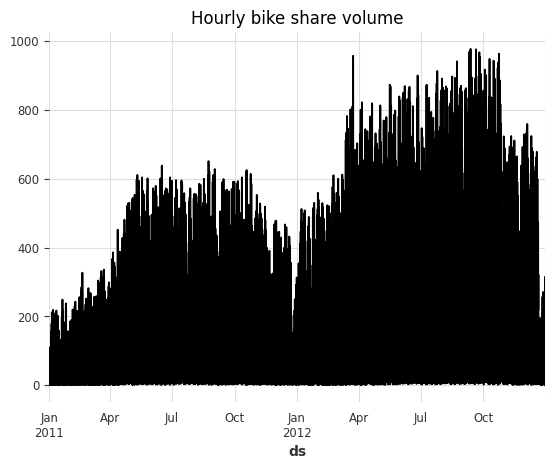

In [12]:
# Plot
df['y'].plot(title = 'Hourly bike share volume')
plt.show()

#### Seasonal Decomposition Plot

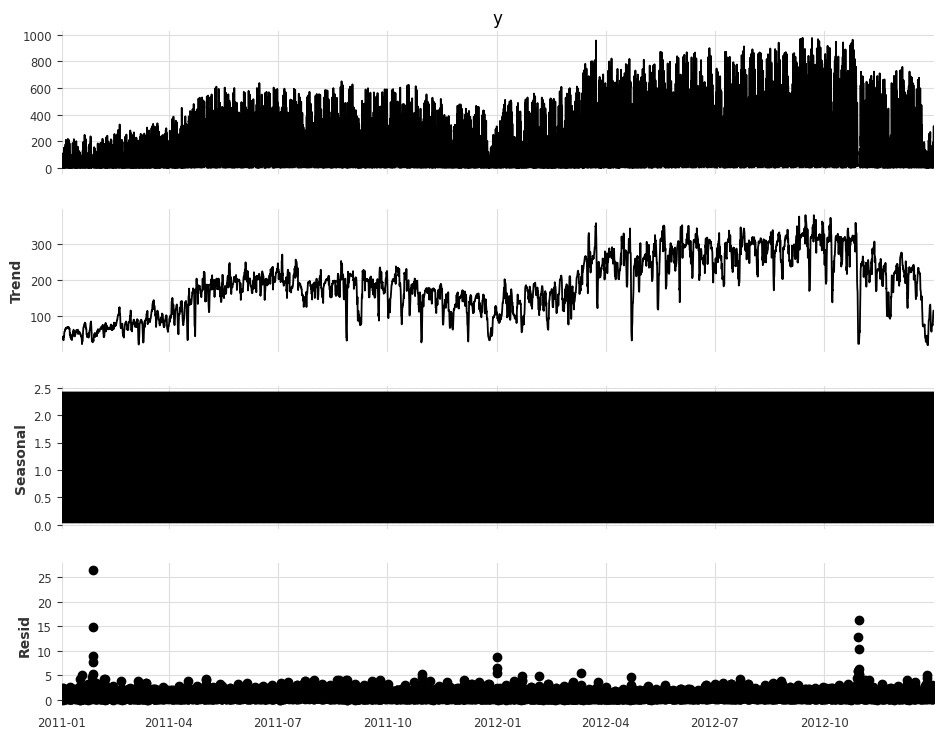

In [13]:
# Perform seasonal decomposition of the electricity price data using an additive model
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 24)

# Plot the decomposed components (trend, seasonal, and residual)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

#### ACF and PACF Plot

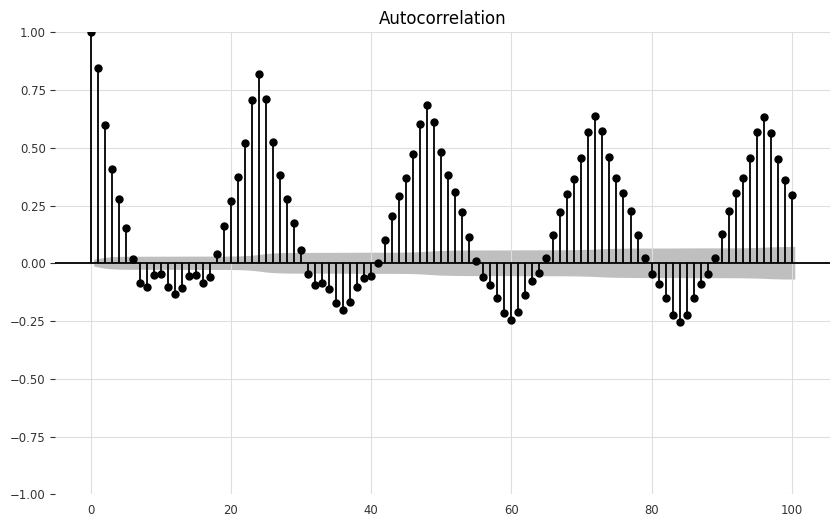

In [14]:
# Plot the autocorrelation function (ACF) for the time series data
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags=100, ax = ax)
plt.show()

# It is seasonal by looking at values at 24, 48, etc

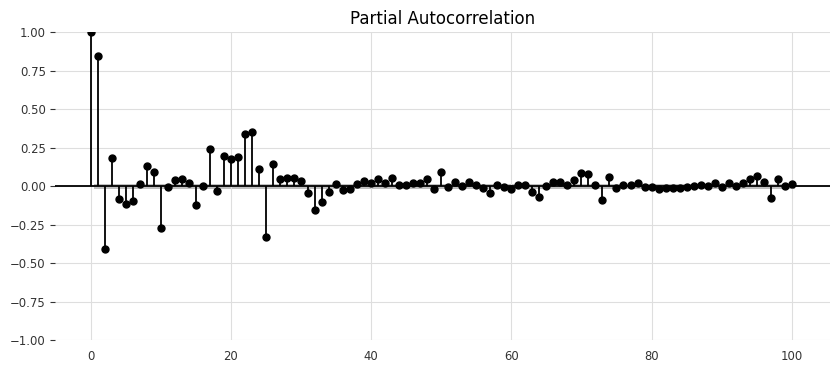

In [15]:
# Plot the partial autocorrelation function (PACF) for the time series data
fig, ax = plt.subplots(figsize = (10,4))
plot_pacf(df['y'], lags=100, ax = ax)
plt.show()

# Based on the PACF there are a lot of information during the past 24 period.

### TSMixer Model

#### Data Preparation for Darts

In [16]:
# Prepare a TimeSeries object from the dataframe with Hourly frequency
series = TimeSeries.from_dataframe(df,
                                   value_cols = 'y',
                                   freq = 'H')
series

<TimeSeries (ds: 17544, component: 1, sample: 1)> Size: 140kB
array([[[16.]],

       [[40.]],

       [[32.]],

       ...,

       [[90.]],

       [[61.]],

       [[49.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 140kB 2011-01-01 ... 2012-12-31T23:00:00
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [17]:
# Function to encode the year as a normalized value
def encode_year(idx):
  return (idx.year - 2000) / 50

# Set up the add_encoders dictionary to specify how different time-related encoders and transformers should be applied
add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week','month']},
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week','month']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'CET'
}

In [18]:
# Convert the past Covariates
X_past = df.iloc[:,:-1]
past_covariates = TimeSeries.from_dataframe(X_past,
                                          freq = 'H')
past_covariates

<TimeSeries (ds: 17544, component: 6, sample: 1)> Size: 842kB
array([[[ 0. ],
        [ 0. ],
        [ 1. ],
        [36.6],
        [81. ],
        [ 0. ]],

       [[ 0. ],
        [ 0. ],
        [ 1. ],
        [34.9],
        [80. ],
        [ 0. ]],

       [[ 0. ],
        [ 0. ],
        [ 1. ],
        [34.9],
        [80. ],
        [ 0. ]],
...
       [[ 0. ],
        [ 1. ],
        [ 1. ],
        [38.3],
        [60. ],
        [11. ]],

       [[ 0. ],
        [ 1. ],
        [ 1. ],
        [38.3],
        [56. ],
        [ 9. ]],

       [[ 0. ],
        [ 1. ],
        [ 1. ],
        [38.3],
        [65. ],
        [ 9. ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 140kB 2011-01-01 ... 2012-12-31T23:00:00
  * component  (component) object 48B 'Holiday' 'Working Day' ... 'Wind Speed'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [19]:
# Import the scaler
scaler1 = Scaler()
scaler2 = Scaler()

# Apply the scaler1 to the time series
series_scaled = scaler1.fit_transform(series)
past_covariates_scaled = scaler2.fit_transform(past_covariates)

#### Model Fitting

- input_chunk_length: how many past time steps the model uses for predictions
- output_chunk_length: forecast horizon
- use_reversible_instance_norm=True: activates reversible instance normalization in model. This adjust the scale of the data within each instant, smoothing oout variation that could confuse the learning process. Making this reversible, let us easily return the model's ooutput to its original sclae after processing.
- ff_size: the ff size (feed forward) controls the model's ability to learn complex patterns. Starting with a size of 5 balances complexity and efficiency.
- activation: the activation function, default is RELU
- dropout: Fraction of neurons affected by dropout.
- num_blocks: indicates how many blocks are included in the model's structure. Each block is a learning layer. More blocks capture complex patterns but take longer to train. With 4 we balance depth and performance.
- hidden_size: the larger the hidden size captures complex data patterns without overfitting
- add_encorders: these encoders improve the model by adding time-based features, enchancing its understand of temporal dynamics
- n_epochs: the number of times we will iterate. More epochs, more learning
- pl_trainer_kwargs: ideally we use a gpu

In [20]:
# Set the forecasting horizon
forecast_horizon = 24

In [21]:
from mmap import ACCESS_DEFAULT

model = TSMixerModel(
    input_chunk_length = 120,                 #Number of time steps in the past to take as a model input (per chunk)
    output_chunk_length = forecast_horizon,   #Number of time steps predicted at once (per chunk) by the internal model.
    add_encoders = add_encoders,
    ff_size = 5,                              #size of the first feed-forward layer in the feature mixing MLP.
    num_blocks= 4,                            #number of mixer blocks
    hidden_size = 20,                         #The hidden state size / size of the second feed-forward layer in the feature mixing MLP
    n_epochs = 10,
    use_reversible_instance_norm = True,
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0]}
    # pl_trainer_kwargs = {"accelerator": "cpu"}
)
model.fit(series_scaled, past_covariates = past_covariates_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 2.9 K  | train
7  | feature_mixing_hist   | _FeatureMixing   | 1.8

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TSMixerModel(output_chunk_shift=0, hidden_size=20, ff_size=5, num_blocks=4, activation=ReLU, dropout=0.1, norm_type=LayerNorm, normalize_before=False, use_static_covariates=True, input_chunk_length=120, output_chunk_length=24, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x7d0ba81edd00>], 'future': [<function encode_year at 0x7d0ba81edd00>]}, 'transformer': Scaler, 'tz': 'CET'}, n_epochs=10, use_reversible_instance_norm=True, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [22]:
model.predict(24)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (ds: 24, component: 1, sample: 1)> Size: 192B
array([[[0.04085635]],

       [[0.02364266]],

       [[0.00525388]],

       [[0.00807221]],

       [[0.00050613]],

       [[0.01774362]],

       [[0.04962726]],

       [[0.10971476]],

       [[0.20026596]],

       [[0.15364894]],

...

       [[0.13645283]],

       [[0.16227911]],

       [[0.22223316]],

       [[0.29611186]],

       [[0.28151519]],

       [[0.20199022]],

       [[0.14709336]],

       [[0.10347732]],

       [[0.07686062]],

       [[0.04086252]]])
Coordinates:
  * ds         (ds) datetime64[ns] 192B 2013-01-01 ... 2013-01-01T23:00:00
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

#### Cross-validation

In [23]:
# Perform Cross-Validation with Rolling Forecast
cv = model.historical_forecasts(
    series = series_scaled,
    past_covariates = past_covariates_scaled,
    start = len(df) - 240,
    forecast_horizon = forecast_horizon,
    retrain = True,
    verbose = True,
    last_points_only = False,
    stride = forecast_horizon
)

historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 2.9 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [01:11<10:40, 71.17s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [02:22<09:31, 71.41s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [03:33<08:17, 71.03s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [04:44<07:06, 71.12s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [05:57<05:58, 71.79s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [07:12<04:51, 72.99s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [08:24<03:37, 72.40s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [09:33<02:23, 71.54s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [10:44<01:11, 71.15s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [11:52<00:00, 71.24s/it]


In [33]:
# Initialize the list to store the RMSE
rmse_cv = []

# Iterate over each fold in the cv results
for i in range(len(cv)):
    # Inverse transform predictions (returns a TimeSeries)
    predictions_ts = scaler1.inverse_transform(cv[i])

    # Convert TimeSeries to pandas Series
    predictions = pd.Series(
        predictions_ts.values().squeeze(),
        index=predictions_ts.time_index
    )

    # Extract the corresponding actual values
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df.loc[start:end, "y"]

    # Compute the RMSE for the current fold
    error_cv = root_mean_squared_error(actuals, predictions)
    rmse_cv.append({"Fold": i+1, "RMSE": error_cv})

# Convert list of dicts to DataFrame and set Fold as index
rmse_df = pd.DataFrame(rmse_cv).set_index("Fold")

# Add a row for the mean RMSE
rmse_df.loc["Mean"] = rmse_df["RMSE"].mean()

# Show results
print(rmse_df)



            RMSE
Fold            
1      58.279963
2      41.662508
3     150.554928
4      80.344520
5      93.215995
6      58.310998
7      78.797841
8      42.301546
9      23.475113
10     80.487123
Mean   70.743054


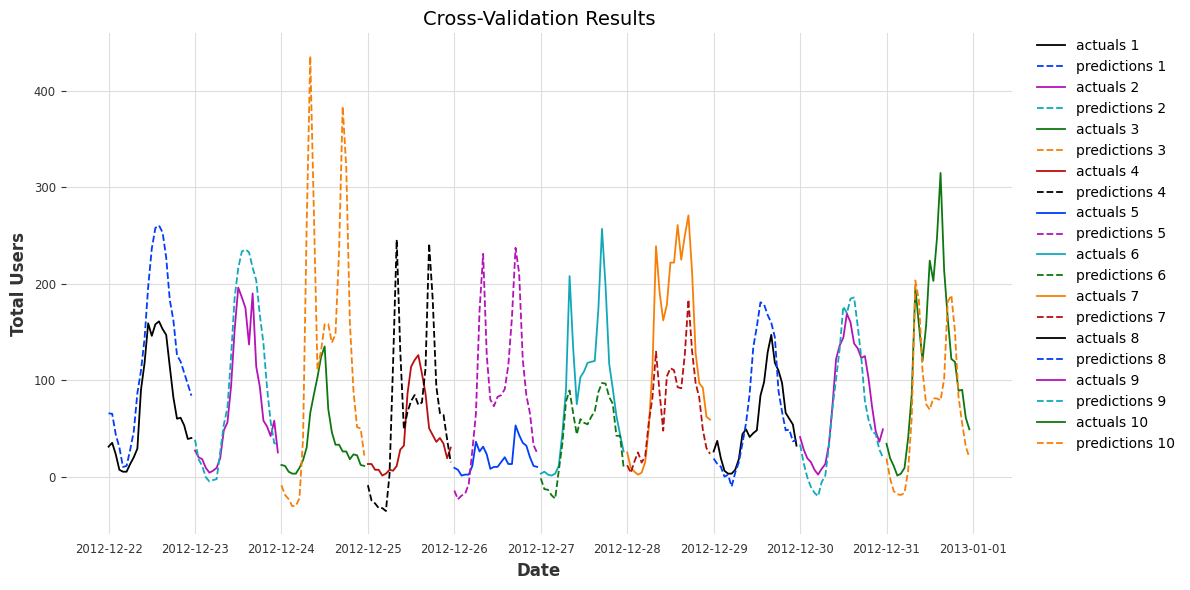

In [31]:
# Set the figure of the subplots
fig, ax = plt.subplots(figsize=(12,6))

# Loop through the cv
for i in range(len(cv)):
    # Get the predictions for the current fold and inverse transform it
    predictions_ts = scaler1.inverse_transform(cv[i])

    # Convert TimeSeries to pandas Series
    predictions = pd.Series(
        predictions_ts.values().squeeze(),
        index=predictions_ts.time_index
    )

    # Retrieve the actuals
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df.loc[start:end, "y"]

    # Plot the predictions
    ax.plot(actuals, label=f"actuals {i+1}")
    ax.plot(predictions, label=f"predictions {i+1}", linestyle="dashed")

# Titles and labels
ax.set_title("Cross-Validation Results", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Total Users", fontsize=12)

# Move legend outside the plot (right side)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

# Adjust layout so nothing is cut off
plt.tight_layout()
plt.show()


#### Parameter Tuning

In [34]:
# Define the Param Grid
param_grid = {
    'input_chunk_length': [72, 96, 120],
    'n_epochs': [5, 10, 15],
    'ff_size': [3,5,7],
    'num_blocks': [2,4,6],
    'hidden_size': [10, 20, 30],
}

In [35]:
# Define the fixed params
fixed_params = {
    'output_chunk_length': forecast_horizon,
    'add_encoders': add_encoders,
    'use_reversible_instance_norm': True,
    'pl_trainer_kwargs': {"accelerator": "gpu", "devices": [0]}
    # 'pl_trainer_kwargs': {"accelerator": "cpu"}
}

In [36]:
# Number of random combinations to geenrate
n_iter = 10

# Generate a a list of random parameter combinations
param_list = list(ParameterSampler(param_grid,
                                   n_iter = n_iter,
                                   random_state = 1502))
param_list

[{'num_blocks': 6,
  'n_epochs': 15,
  'input_chunk_length': 120,
  'hidden_size': 20,
  'ff_size': 7},
 {'num_blocks': 6,
  'n_epochs': 15,
  'input_chunk_length': 120,
  'hidden_size': 30,
  'ff_size': 5},
 {'num_blocks': 2,
  'n_epochs': 15,
  'input_chunk_length': 72,
  'hidden_size': 30,
  'ff_size': 3},
 {'num_blocks': 6,
  'n_epochs': 15,
  'input_chunk_length': 72,
  'hidden_size': 20,
  'ff_size': 7},
 {'num_blocks': 4,
  'n_epochs': 15,
  'input_chunk_length': 120,
  'hidden_size': 20,
  'ff_size': 3},
 {'num_blocks': 2,
  'n_epochs': 10,
  'input_chunk_length': 72,
  'hidden_size': 10,
  'ff_size': 3},
 {'num_blocks': 6,
  'n_epochs': 5,
  'input_chunk_length': 96,
  'hidden_size': 10,
  'ff_size': 3},
 {'num_blocks': 2,
  'n_epochs': 10,
  'input_chunk_length': 72,
  'hidden_size': 20,
  'ff_size': 7},
 {'num_blocks': 2,
  'n_epochs': 10,
  'input_chunk_length': 120,
  'hidden_size': 20,
  'ff_size': 3},
 {'num_blocks': 2,
  'n_epochs': 10,
  'input_chunk_length': 72,
  'hi

In [37]:
# Update each parameter
for params in param_list:
  params.update(fixed_params)

In [38]:
# Create an empty list for the RMSE
total_rmse = []

# Iterate over the parameter combinations
for params in param_list:
  # Build the model
  model = TSMixerModel(**params)

  # Perform the Cross Validation
  cv = model.historical_forecasts(
      series = series_scaled,
      past_covariates = past_covariates_scaled,
      start = len(df) - 240,
      forecast_horizon = forecast_horizon,
      retrain = True,
      verbose = True,
      last_points_only = False,
      stride = forecast_horizon
  )

  # Create an empty list for the CV
  rmse_cv = []

  # Iterate over the results to compute the RMSE
  for i in range(len(cv)):
    # Converting the predictions
    predictions = TimeSeries.pd_series(scaler1.inverse_transform(cv[i]))

    # Retrieve the actual values
    start = predictions.index.min()
    end = predictions.index.max()
    actuals = df.y[start:end]

    # Compute the RMSE
    error_cv = root_mean_squared_error(actuals, predictions)
    rmse_cv.append(error_cv)

  # Append the mean of the RMSE
  mean_rmse = np.mean(rmse_cv)
  total_rmse.append(np.mean(rmse_cv))
  print(f"The mean RMSE for fold {i+1} is {mean_rmse}")


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 2.9 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [01:58<17:50, 118.98s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [04:00<16:04, 120.52s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [06:02<14:09, 121.33s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [08:07<12:15, 122.66s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [10:18<10:28, 125.67s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [12:20<08:18, 124.50s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [14:23<06:11, 123.95s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [16:26<04:07, 123.68s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [18:28<02:03, 123.23s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [20:32<00:00, 123.23s/it]


AttributeError: type object 'TimeSeries' has no attribute 'pd_series'

In [39]:
# Create an empty list for the RMSE
total_rmse = []

# Iterate over the parameter combinations
for p_idx, params in enumerate(param_list, start=1):
    # Build the model
    model = TSMixerModel(**params)

    # Perform the Cross Validation
    cv = model.historical_forecasts(
        series=series_scaled,
        past_covariates=past_covariates_scaled,
        start=len(df) - 240,
        forecast_horizon=forecast_horizon,
        retrain=True,
        verbose=True,
        last_points_only=False,
        stride=forecast_horizon
    )

    # Create an empty list for the CV
    rmse_cv = []

    # Iterate over the results to compute the RMSE
    for i in range(len(cv)):
        # Inverse transform predictions
        predictions_ts = scaler1.inverse_transform(cv[i])

        # Convert TimeSeries to pandas Series
        predictions = pd.Series(
            predictions_ts.values().squeeze(),
            index=predictions_ts.time_index
        )

        # Retrieve the actual values
        start = predictions.index.min()
        end = predictions.index.max()
        actuals = df.loc[start:end, "y"]

        # Compute the RMSE
        error_cv = root_mean_squared_error(actuals, predictions)
        rmse_cv.append(error_cv)

    # Append the mean RMSE
    mean_rmse = np.mean(rmse_cv)
    total_rmse.append({"Params": params, "Mean_RMSE": mean_rmse})
    print(f"Params set {p_idx}: Mean RMSE = {mean_rmse:.3f}")

# Convert results to DataFrame for easier viewing
rmse_df = pd.DataFrame(total_rmse)
print(rmse_df)


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 2.9 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [02:05<18:52, 125.83s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [04:09<16:34, 124.32s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [06:13<14:29, 124.17s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [08:15<12:21, 123.59s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [10:19<10:17, 123.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [12:22<08:14, 123.56s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [14:26<06:11, 123.74s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [16:30<04:07, 123.59s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [18:35<02:04, 124.21s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [20:39<00:00, 123.97s/it]


Params set 1: Mean RMSE = 64.646


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 2.9 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [02:03<18:27, 123.06s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [04:06<16:26, 123.33s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [06:10<14:24, 123.57s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [08:13<12:20, 123.39s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [10:16<10:16, 123.40s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [12:20<08:13, 123.29s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [14:23<06:10, 123.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [16:27<04:06, 123.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [18:32<02:03, 123.98s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [20:37<00:00, 123.73s/it]


Params set 2: Mean RMSE = 57.890


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 1.8 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [01:21<12:11, 81.30s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [02:42<10:50, 81.30s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [04:03<09:29, 81.30s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [05:25<08:08, 81.42s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [06:47<06:48, 81.69s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [08:09<05:27, 81.76s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [09:31<04:05, 81.82s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [10:53<02:43, 82.00s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [12:17<01:22, 82.37s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [13:39<00:00, 81.95s/it]


Params set 3: Mean RMSE = 65.925


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 1.8 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [02:03<18:31, 123.45s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [04:07<16:28, 123.52s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [06:10<14:24, 123.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [08:14<12:22, 123.74s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [10:18<10:18, 123.77s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [12:22<08:15, 123.97s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [14:27<06:12, 124.17s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [16:32<04:08, 124.32s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [18:36<02:04, 124.52s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [20:41<00:00, 124.16s/it]


Params set 4: Mean RMSE = 58.487


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 2.9 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [01:43<15:29, 103.25s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [03:26<13:45, 103.18s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [05:09<12:03, 103.35s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [06:53<10:21, 103.52s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [08:37<08:38, 103.60s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [10:21<06:55, 103.76s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [12:05<05:11, 103.99s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [13:50<03:28, 104.01s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [15:35<01:44, 104.43s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [17:20<00:00, 104.02s/it]


Params set 5: Mean RMSE = 76.518


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 1.8 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [00:54<08:12, 54.72s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [01:49<07:16, 54.57s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [02:45<06:26, 55.20s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [03:42<05:36, 56.03s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [04:39<04:41, 56.38s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [05:35<03:44, 56.21s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [06:31<02:48, 56.07s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [07:27<01:52, 56.18s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [08:23<00:56, 56.17s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [09:19<00:00, 55.95s/it]


Params set 6: Mean RMSE = 61.232


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 2.3 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [00:41<06:14, 41.66s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [01:23<05:33, 41.69s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [02:06<04:55, 42.17s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [02:48<04:12, 42.09s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [03:30<03:30, 42.11s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [04:12<02:48, 42.09s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [04:54<02:06, 42.27s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [05:38<01:25, 42.64s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [06:20<00:42, 42.54s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [07:03<00:00, 42.32s/it]


Params set 7: Mean RMSE = 76.342


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 1.8 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [00:56<08:29, 56.56s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [01:52<07:31, 56.46s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [02:48<06:33, 56.17s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [03:44<05:36, 56.12s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [04:40<04:40, 56.11s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [05:37<03:45, 56.38s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [06:34<02:49, 56.47s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [07:30<01:52, 56.45s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [08:27<00:56, 56.50s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [09:25<00:00, 56.53s/it]


Params set 8: Mean RMSE = 69.377


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 2.9 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [00:56<08:27, 56.42s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [01:52<07:30, 56.37s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [02:49<06:36, 56.68s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [03:46<05:41, 56.84s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [04:43<04:44, 56.85s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [05:40<03:47, 56.89s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [06:38<02:52, 57.34s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [07:36<01:54, 57.33s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [08:33<00:57, 57.33s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [09:32<00:00, 57.20s/it]


Params set 9: Mean RMSE = 76.469


historical forecasts:   0%|          | 0/10 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 1.8 K 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  10%|█         | 1/10 [00:56<08:29, 56.63s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  20%|██        | 2/10 [02:00<08:05, 60.72s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  30%|███       | 3/10 [03:02<07:09, 61.40s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  40%|████      | 4/10 [04:04<06:08, 61.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  50%|█████     | 5/10 [05:02<05:02, 60.41s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  60%|██████    | 6/10 [05:59<03:56, 59.21s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  70%|███████   | 7/10 [07:04<03:03, 61.05s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  80%|████████  | 8/10 [08:05<02:02, 61.07s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts:  90%|█████████ | 9/10 [09:04<01:00, 60.60s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


historical forecasts: 100%|██████████| 10/10 [10:02<00:00, 60.24s/it]

Params set 10: Mean RMSE = 61.640
                                              Params  Mean_RMSE
0  {'num_blocks': 6, 'n_epochs': 15, 'input_chunk...  64.646395
1  {'num_blocks': 6, 'n_epochs': 15, 'input_chunk...  57.890381
2  {'num_blocks': 2, 'n_epochs': 15, 'input_chunk...  65.924755
3  {'num_blocks': 6, 'n_epochs': 15, 'input_chunk...  58.486943
4  {'num_blocks': 4, 'n_epochs': 15, 'input_chunk...  76.518346
5  {'num_blocks': 2, 'n_epochs': 10, 'input_chunk...  61.231994
6  {'num_blocks': 6, 'n_epochs': 5, 'input_chunk_...  76.342316
7  {'num_blocks': 2, 'n_epochs': 10, 'input_chunk...  69.377469
8  {'num_blocks': 2, 'n_epochs': 10, 'input_chunk...  76.469446
9  {'num_blocks': 2, 'n_epochs': 10, 'input_chunk...  61.640308


In [2]:
# Create a dataframe and add the RMSE values
results_df = pd.DataFrame(param_list)
results_df['RMSE'] = total_rmse
results_df

NameError: name 'pd' is not defined

In [1]:
# save as csv
results.loc[results["RMSE"].idxmin()].to_csv("best_params_tsmixer.csv")

NameError: name 'results' is not defined

In [51]:
# Identify the parameter set with the lowest RMSE
best_params = rmse_df.loc[rmse_df['Mean_RMSE'].idxmin()]

# Display best parameters
best_params


Params       {'num_blocks': 6, 'n_epochs': 15, 'input_chunk...
Mean_RMSE                                            57.890381
Name: 1, dtype: object

### Future Predictions

In [16]:
best_params = pd.read_csv('best_params_tsmixer.csv', index_col = 0)
best_params

EmptyDataError: No columns to parse from file

In [10]:
# Isolate the parameters
hidden_size = int(best_params.loc['hidden_size'].values[0])
num_blocks = int(best_params.loc['num_blocks'].values[0])
ff_size = int(best_params.loc['ff_size'].values[0])
input_chunk_length = int(best_params.loc['input_chunk_length'].values[0])
dropout = float(best_params.loc['dropout'].values[0])
n_epochs = int(best_params.loc['n_epochs'].values[0])

KeyError: 'hidden_size'

In [ ]:
# Build the Tuned Model
tuned_model = TSMixerModel(
    input_chunk_length = input_chunk_length,
    output_chunk_length = forecasting_horizon,
    add_encoders = add_encoders,
    n_epochs = n_epochs,
    hidden_size=hidden_size,
    ff_size = ff_size,
    num_blocks = num_blocks,
    dropout = dropout,
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0]}
)
tuned_model.fit(series_scaled, past_covariates = past_covariates_scaled)

In [ ]:
# Predict with the tuned model and transform into a pandas series
forecast = tuned_model.predict(n = forecasting_horizon,
                          past_covariates = past_covariates_scaled)
forecast = TimeSeries.to_series(scaler1.inverse_transform(forecast))
forecast

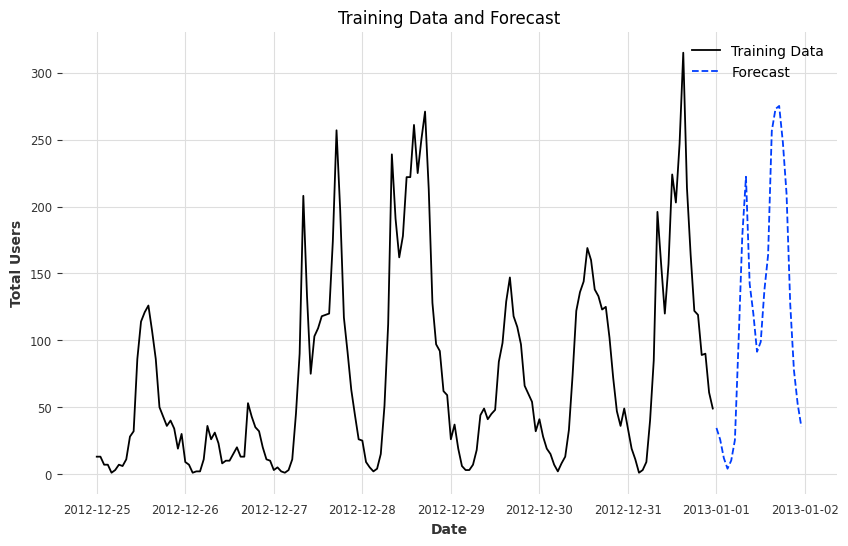

In [ ]:
# Visualize the predictions and training data
fig, ax = plt.subplots(figsize = (12,5))

# Plot the predictions and actuals
ax.plot(forecast, label = 'Forecast', linestyle = "dashed")
ax.plot(df.y['2012-12'], label = 'Actuals')

# Set the legend, xlabel, ylabel, and title
ax.legend()
ax.set_title("Forecast vs Actuals")
ax.set_xlabel("Date")
ax.set_ylabel("Total Users")
plt.show()